In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
def parse_lines_with_sep(path, maxsplit=None):
    """
    Read file and split lines by ' ::: ' into parts.
    If maxsplit is provided, it's passed to str.split.
    Returns list of lists of parts (trimmed).
    """
    rows = []
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            # try splitting by ' ::: ' first (space-surrounded)
            if maxsplit is None:
                parts = [p.strip() for p in line.split(' ::: ')]
            else:
                parts = [p.strip() for p in line.split(' ::: ', maxsplit)]
            # fallback: if splitting by ' ::: ' didn't work (no separators), try ':::' without spaces
            if len(parts) == 1 and ':::' in line:
                if maxsplit is None:
                    parts = [p.strip() for p in line.split(':::')]
                else:
                    parts = [p.strip() for p in line.split(':::', maxsplit)]
            rows.append(parts)
    return rows

In [3]:
train_path = "/content/train_data.txt"
test_path  = "/content/test_data.txt"
sol_path   = "/content/test_data_solution.txt"

In [4]:
for p in (train_path, test_path, sol_path):
    if not os.path.exists(p):
        raise FileNotFoundError(f"Expected file not found: {p}")

In [5]:
train_parsed = parse_lines_with_sep(train_path, maxsplit=3)
train_records = []
for parts in train_parsed:
    # Expecting: id, title, genre, plot  (>=4 parts)
    if len(parts) >= 4:
        rec_id = parts[0]
        title  = parts[1]
        genre  = parts[2]
        plot   = parts[3]
    elif len(parts) == 3:
        # fallback: maybe id, title, plot (no genre) - treat genre as missing
        rec_id = parts[0]
        title  = parts[1]
        genre  = None
        plot   = parts[2]
    else:
        # too few parts: skip
        continue
    # combine title + plot (helps short plots)
    full_text = (title or "") + " . " + (plot or "")
    train_records.append({'id': rec_id, 'title': title, 'genre': genre, 'plot': plot, 'text': full_text})

train_df = pd.DataFrame(train_records)
# Drop rows without genre (training requires labels)
train_df = train_df.dropna(subset=['genre']).reset_index(drop=True)
print("Loaded train set:", train_df.shape)
display(train_df.head())

Loaded train set: (54214, 5)


,id,title,genre,plot,text
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...,Oscar et la dame rose (2009) . Listening in to...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...,Cupid (1997) . A brother and sister with a pas...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...,"Young, Wild and Wonderful (1980) . As the bus ..."
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...,The Secret Sin (1915) . To help their unemploy...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...,The Unrecovered (2007) . The film's title refe...


In [6]:
test_parsed = parse_lines_with_sep(test_path, maxsplit=2)
test_records = []
for parts in test_parsed:
    # Expecting: id, title, plot  (3 parts)
    if len(parts) >= 3:
        rec_id = parts[0]
        title  = parts[1]
        plot   = parts[2]
    elif len(parts) == 2:
        rec_id = parts[0]
        title  = parts[1]
        plot   = ""
    else:
        continue
    full_text = (title or "") + " . " + (plot or "")
    test_records.append({'id': rec_id, 'title': title, 'plot': plot, 'text': full_text})

test_df = pd.DataFrame(test_records).reset_index(drop=True)
print("Loaded test set:", test_df.shape)
display(test_df.head())

Loaded test set: (54200, 4)


,id,title,plot,text
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apart...",Edgar's Lunch (1998) . L.R. Brane loves his li...
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty chi...","La guerra de papá (1977) . Spain, March 1964: ..."
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family o...,Off the Beaten Track (2010) . One year in the ...
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with his...","Meu Amigo Hindu (2015) . His father has died, ..."
4,5,Er nu zhai (1955),Before he was known internationally as a marti...,Er nu zhai (1955) . Before he was known intern...


In [7]:
sol_parsed = parse_lines_with_sep(sol_path, maxsplit=2)
sol_records = []
for parts in sol_parsed:
    if len(parts) >= 3:
        rec_id = parts[0]
        title  = parts[1]
        genre  = parts[2]
        sol_records.append({'id': rec_id, 'title': title, 'genre': genre})
    else:
        continue

sol_df = pd.DataFrame(sol_records).reset_index(drop=True)
print("Loaded solutions:", sol_df.shape)
display(sol_df.head())

# Merge solution genres into test_df (by id)
# Ensure id types match (string)
test_df['id'] = test_df['id'].astype(str)
sol_df['id']  = sol_df['id'].astype(str)
test_df = test_df.merge(sol_df[['id','genre']], on='id', how='left')
print("Test set after merging solutions (genre column added when available):")
display(test_df.head())

Loaded solutions: (54200, 3)


,id,title,genre
0,1,Edgar's Lunch (1998),drama
1,2,La guerra de papá (1977),drama
2,3,Off the Beaten Track (2010),documentary
3,4,Meu Amigo Hindu (2015),drama
4,5,Er nu zhai (1955),drama


Test set after merging solutions (genre column added when available):


,id,title,plot,text,genre
0,1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apart...",Edgar's Lunch (1998) . L.R. Brane loves his li...,drama
1,2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty chi...","La guerra de papá (1977) . Spain, March 1964: ...",drama
2,3,Off the Beaten Track (2010),One year in the life of Albin and his family o...,Off the Beaten Track (2010) . One year in the ...,documentary
3,4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with his...","Meu Amigo Hindu (2015) . His father has died, ...",drama
4,5,Er nu zhai (1955),Before he was known internationally as a marti...,Er nu zhai (1955) . Before he was known intern...,drama


In [8]:
train_texts = train_df['text'].astype(str).tolist()
train_labels = train_df['genre'].astype(str).tolist()

# Encode labels
le = LabelEncoder()
y = le.fit_transform(train_labels)
label_names = le.classes_.tolist()
print("Detected genre classes:", label_names)

# Split training data into train/validation for internal evaluation
X_train_text, X_val_text, y_train, y_val = train_test_split(
    train_texts, y, test_size=0.2, stratify=y, random_state=42
)

Detected genre classes: ['action', 'adult', 'adventure', 'animation', 'biography', 'comedy', 'crime', 'documentary', 'drama', 'family', 'fantasy', 'game-show', 'history', 'horror', 'music', 'musical', 'mystery', 'news', 'reality-tv', 'romance', 'sci-fi', 'short', 'sport', 'talk-show', 'thriller', 'war', 'western']


In [9]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=40000)
X_train = vectorizer.fit_transform(X_train_text)
X_val   = vectorizer.transform(X_val_text)

# Prepare test set vectors (only those with solution genres for evaluation)
test_with_sol = test_df.dropna(subset=['genre']).copy()
test_with_sol['genre'] = test_with_sol['genre'].astype(str)
X_test_texts = test_with_sol['text'].astype(str).tolist()
X_test = vectorizer.transform(X_test_texts)
y_test = le.transform(test_with_sol['genre'])  # this will error if test genre contains unseen label - handle below

# If test contains genres unseen in training, handle by mapping or warning
unseen_labels = set(test_with_sol['genre'].unique()) - set(label_names)
if unseen_labels:
    print("Warning: the following genre labels appear in test solutions but not in train labels:", unseen_labels)

In [10]:
print("\nTraining models...")
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced'),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC()
}

fitted = {}
for name, m in models.items():
    print(" - fitting", name)
    fitted[name] = m.fit(X_train, y_train)

print("Training complete.")


Training models...
 - fitting Logistic Regression
 - fitting Naive Bayes
 - fitting Linear SVM
Training complete.


In [11]:
def eval_and_plot(name, model, Xs, ys_true, labels):
    ys_pred = model.predict(Xs)
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(ys_true, ys_pred))
    print(classification_report(ys_true, ys_pred, target_names=labels, zero_division=0))
    cm = confusion_matrix(ys_true, ys_pred, labels=range(len(labels)))
    plt.figure(figsize=(7,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()
    return ys_pred


Validation set evaluation (internal split):

=== Logistic Regression ===
Accuracy: 0.5006916904915614
              precision    recall  f1-score   support

      action       0.33      0.52      0.41       263
       adult       0.41      0.75      0.53       118
   adventure       0.23      0.35      0.28       155
   animation       0.22      0.31      0.25       100
   biography       0.02      0.04      0.03        53
      comedy       0.60      0.46      0.52      1490
       crime       0.14      0.29      0.19       101
 documentary       0.78      0.61      0.68      2619
       drama       0.70      0.41      0.52      2723
      family       0.16      0.33      0.21       157
     fantasy       0.15      0.26      0.19        65
   game-show       0.73      0.69      0.71        39
     history       0.11      0.29      0.16        49
      horror       0.60      0.72      0.65       441
       music       0.40      0.81      0.54       146
     musical       0.12      0.2

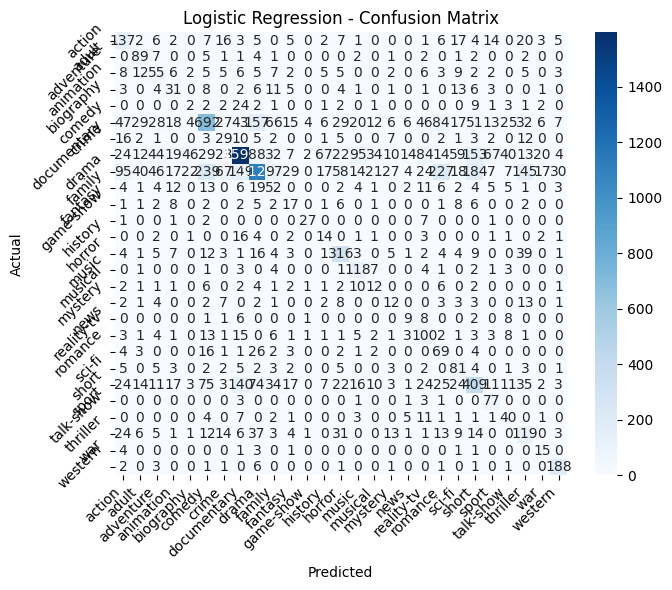


=== Naive Bayes ===
Accuracy: 0.46306372775062254
              precision    recall  f1-score   support

      action       0.00      0.00      0.00       263
       adult       0.00      0.00      0.00       118
   adventure       0.00      0.00      0.00       155
   animation       0.00      0.00      0.00       100
   biography       0.00      0.00      0.00        53
      comedy       0.63      0.16      0.25      1490
       crime       0.00      0.00      0.00       101
 documentary       0.53      0.91      0.67      2619
       drama       0.40      0.88      0.55      2723
      family       0.00      0.00      0.00       157
     fantasy       0.00      0.00      0.00        65
   game-show       0.00      0.00      0.00        39
     history       0.00      0.00      0.00        49
      horror       0.86      0.01      0.03       441
       music       0.00      0.00      0.00       146
     musical       0.00      0.00      0.00        55
     mystery       0.00      0

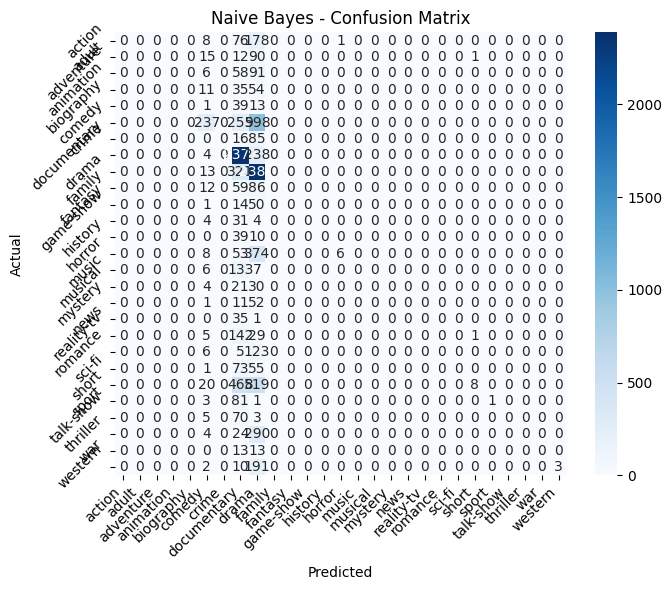


=== Linear SVM ===
Accuracy: 0.5795444065295582
              precision    recall  f1-score   support

      action       0.46      0.35      0.40       263
       adult       0.71      0.47      0.57       118
   adventure       0.46      0.23      0.30       155
   animation       0.30      0.13      0.18       100
   biography       0.00      0.00      0.00        53
      comedy       0.53      0.58      0.55      1490
       crime       0.35      0.06      0.10       101
 documentary       0.68      0.82      0.74      2619
       drama       0.57      0.70      0.63      2723
      family       0.32      0.13      0.19       157
     fantasy       0.22      0.03      0.05        65
   game-show       0.91      0.54      0.68        39
     history       0.40      0.04      0.07        49
      horror       0.64      0.64      0.64       441
       music       0.66      0.49      0.56       146
     musical       0.29      0.07      0.12        55
     mystery       0.33      0.0

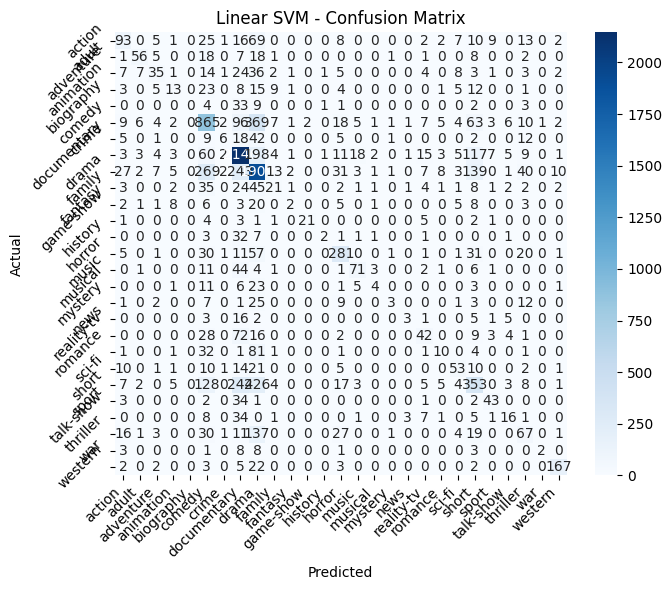

In [12]:
print("\nValidation set evaluation (internal split):")
for name, model in fitted.items():
    eval_and_plot(name, model, X_val, y_val, label_names)


Test set evaluation (using test_data_solution.txt):

=== Logistic Regression ===
Accuracy: 0.5341881918819188
              precision    recall  f1-score   support

      action       0.26      0.80      0.39       643
       adult       0.17      0.96      0.28       192
   adventure       0.12      0.88      0.21       156
   animation       0.03      0.85      0.05        20
   biography       0.00      0.00      0.00         0
      comedy       0.74      0.53      0.62      7989
       crime       0.02      0.91      0.03        23
 documentary       0.96      0.57      0.71     17314
       drama       0.98      0.39      0.56     20450
      family       0.06      0.89      0.11       104
     fantasy       0.02      1.00      0.03         9
   game-show       0.43      1.00      0.60        99
     history       0.00      0.00      0.00         0
      horror       0.59      0.85      0.70      1882
       music       0.27      0.96      0.43       411
     musical       0.01 

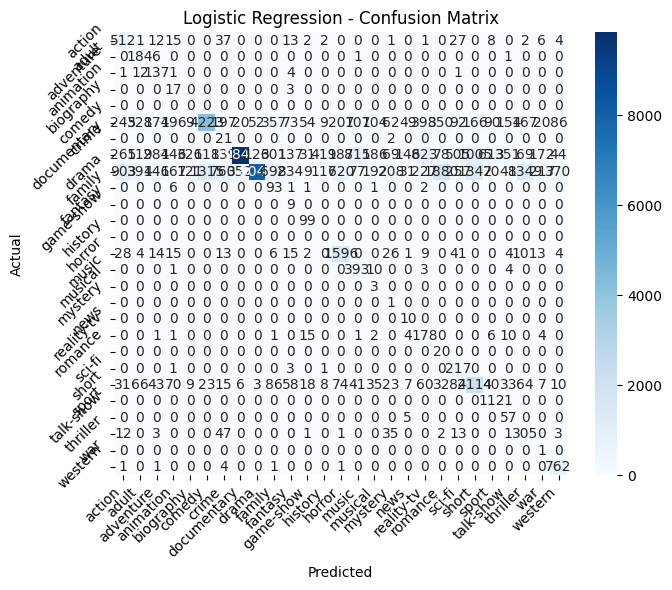


=== Naive Bayes ===
Accuracy: 0.6835977859778598
Evaluation error for Naive Bayes: Number of classes, 25, does not match size of target_names, 27. Try specifying the labels parameter

=== Linear SVM ===
Accuracy: 0.7847232472324723
              precision    recall  f1-score   support

      action       0.48      0.77      0.60       643
       adult       0.42      0.80      0.55       192
   adventure       0.38      0.88      0.53       156
   animation       0.10      0.85      0.19        20
   biography       0.00      0.00      0.00         0
      comedy       0.75      0.75      0.75      7989
       crime       0.08      0.39      0.14        23
 documentary       0.91      0.83      0.87     17314
       drama       0.90      0.75      0.82     20450
      family       0.26      0.73      0.38       104
     fantasy       0.10      0.78      0.18         9
   game-show       0.65      0.97      0.78        99
     history       0.00      0.00      0.00         0
      horr

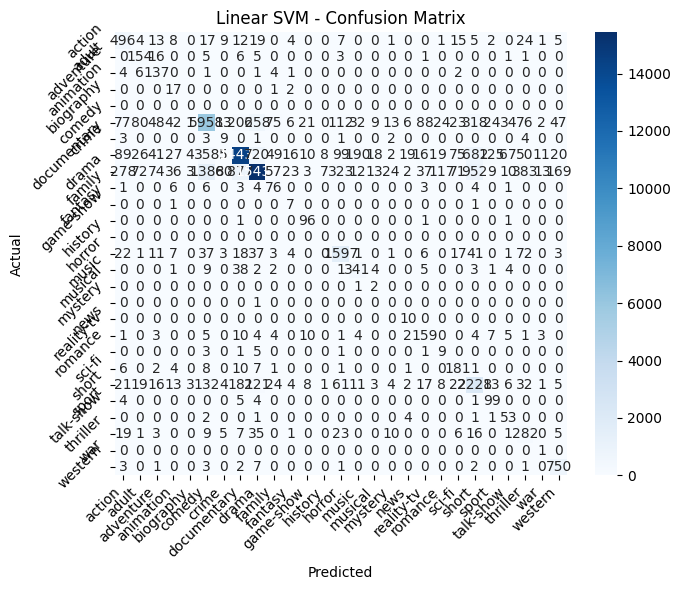

In [13]:
if not test_with_sol.empty:
    print("\nTest set evaluation (using test_data_solution.txt):")
    for name, model in fitted.items():
        # If test contains unseen labels not in training, skip those rows for evaluation
        try:
            eval_and_plot(name, model, X_test, y_test, label_names)
        except Exception as e:
            print(f"Evaluation error for {name}: {e}")
else:
    print("No test solutions available to evaluate against.")

In [14]:
print("\nSample predictions on test set (first 10 rows):")
sample_size = min(10, len(test_df))
sample = test_df.head(sample_size).copy()
sample_texts = sample['text'].astype(str).tolist()
X_sample = vectorizer.transform(sample_texts)
preds = fitted['Logistic Regression'].predict(X_sample)
sample['predicted_genre'] = [le.classes_[p] for p in preds]
display(sample[['id','title','genre','predicted_genre']])


Sample predictions on test set (first 10 rows):


,id,title,genre,predicted_genre
0,1,Edgar's Lunch (1998),drama,short
1,2,La guerra de papá (1977),drama,drama
2,3,Off the Beaten Track (2010),documentary,documentary
3,4,Meu Amigo Hindu (2015),drama,drama
4,5,Er nu zhai (1955),drama,drama
5,6,Riddle Room (2016),drama,thriller
6,7,L'amica (1969),drama,drama
7,8,Ina Mina Dika (1989),comedy,comedy
8,9,Equinox Special: Britain's Tornados (2005),documentary,documentary
9,10,Press (2011),drama,short
